In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image, nd
from mxnet.gluon import data as gdata, utils as gutils
import os
import sys
import tarfile

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def download_voc_pascal(data_dir='../data'):
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gutils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal()

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images()

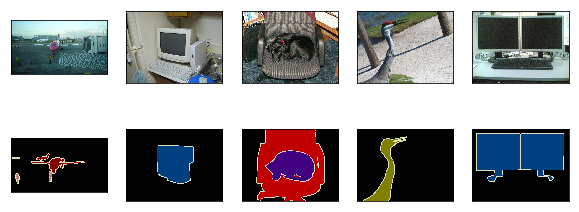

In [7]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

In [8]:
# 该常量已保存在d2lzh包中方便以后使用
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 该常量已保存在d2lzh包中方便以后使用
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [9]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在d2lzh包中方便以后使用
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [10]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>,
 'aeroplane')

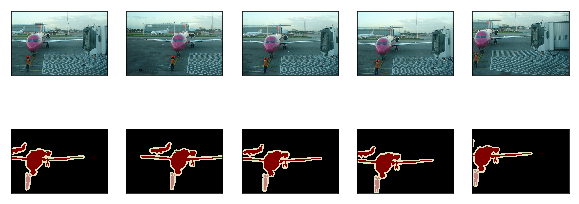

In [11]:
def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [12]:
# 本类已保存在d2lzh包中方便以后使用
class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [13]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 1114 examples
read 1078 examples


In [14]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True,
                              last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard',
                             num_workers=num_workers)

In [15]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


In [16]:
colormap2label 


[0. 0. 0. ... 0. 0. 0.]
<NDArray 16777216 @cpu(0)>